# Goal

* Based on scRecounter cell counts and SRA metadata on dataset release dates, assess the cell counts over time for SRA

In [21]:
import os
from pathlib import Path
import pandas as pd
import plotnine as pn
from pypika import Query, Table, functions as fn
from SRAgent.db.connect import db_connect
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 4)

In [3]:
# get base of github repo
base_dir = !git rev-parse --show-toplevel
base_dir = Path(base_dir[0])
base_dir

PosixPath('/home/nickyoungblut/dev/python/scBaseCount_analysis')

# Get release dates

In [4]:
# obtaining the release dates
exe = base_dir.parent / "SRAgent" / "scripts" / "get-srx-date.py"
!{exe} --help

usage: get-srx-date.py [-h] [--accessions ACCESSIONS [ACCESSIONS ...]]
                       [--use-db] [--output OUTPUT] [--limit LIMIT]
                       [--tenant {test,prod}] [--batch-size BATCH_SIZE]
                       [--retries RETRIES]

Obtain the release dates for SRA experiment accessions

options:
  -h, --help            show this help message and exit
  --accessions ACCESSIONS [ACCESSIONS ...]
                        SRX accessions to use (default: None)
  --use-db              Use the database to get the SRX accessions (default:
                        False)
  --output OUTPUT       Output file name (default: srx_dates.csv)
  --limit LIMIT         Limit the number of records to process (default: None)
  --tenant {test,prod}  Database tenant to use (default: test)
  --batch-size BATCH_SIZE
                        Number of accessions to process per BigQuery batch
                        (default: 50)
  --retries RETRIES     Number of retries for failed BigQuery or

In [24]:
# run the script to get the release dates
release_date_file = base_dir / "data" / "get-srx-date" / "2025-06-13_SRX-release-dates.csv"
#!{exe} --tenant prod --use-db --output {release_date_file}

In [25]:
df_release_dates = pd.read_csv(release_date_file)
df_release_dates

,srx_accession,release_date
0,SRX7016897,2019-10-18
1,SRX7016896,2019-10-18
...,...,...
58855,SRX28717889,NaN
58856,SRX24000343,NaN


In [26]:
# number NaN for release_date
df_release_dates["release_date"].isna().sum()

np.int64(41)

# Get scRecounter cell counts 

In [11]:
# set tenant
os.environ["DYNACONF"] = "prod"

In [23]:
def get_screcounter_star_results(
    conn, 
    feature="GeneFull_Ex50pAS"
):
    """
    Get the screcounter_star_results table
    
    Args:
        conn: A database connection object (e.g., sqlite3, psycopg2, etc.)
        feature: String of the feature to filter on
    Returns:
        A pandas DataFrame of records
    """
    
    # Define tables
    meta_table = Table('srx_metadata')
    star_table = Table('screcounter_star_results')
    
    # Build the star query with feature filter (case insensitive)
    star_query = (
        Query.from_(star_table)
        .select('*')
        .where(
            fn.Lower(star_table.feature) == feature.lower()
        )
    )

    #return pd.read_sql_query(str(star_query), conn)
    
    # Build the main query with join
    # Assuming you want all columns from both tables except feature from star and _at columns from meta
    main_query = (
        Query.from_(star_table)
        .join(meta_table)
        .on(star_table.sample == meta_table.srx_accession)
        .select(
            star_table.sample.as_('srx_accession'),
            star_table.feature,
            star_table.estimated_number_of_cells,
            meta_table.lib_prep,
            meta_table.tech_10x,
            meta_table.organism,
            meta_table.tissue,
            meta_table.tissue_ontology_term_id,
        )
        .where(
            fn.Lower(star_table.feature) == feature.lower()
        )
    )
    
    # Execute query and return as DataFrame
    return pd.read_sql_query(str(main_query), conn)

with db_connect() as conn:
    df_cells = get_screcounter_star_results(conn, feature="GeneFull_Ex50pAS")
df_cells

,srx_accession,feature,estimated_number_of_cells,lib_prep,tech_10x,organism,tissue,tissue_ontology_term_id
0,SRX28055923,GeneFull_Ex50pAS,4700,10x_Genomics,3_prime_gex,Sus scrofa,porcine kidney cells (SK6),UBERON:0002113
1,SRX22482811,GeneFull_Ex50pAS,4155,10x_Genomics,5_prime_gex,Homo sapiens,blood,UBERON:0000178
...,...,...,...,...,...,...,...,...
58862,SRX25954305,GeneFull_Ex50pAS,5266,10x_Genomics,3_prime_gex,Danio rerio,Endothelial cells,UBERON:0001986
58863,SRX15390830,GeneFull_Ex50pAS,22447,10x_Genomics,3_prime_gex,Homo sapiens,unsure,


# Join

In [27]:
# merge the two dataframes
df_cells = df_cells.merge(df_release_dates, on="srx_accession", how="left")
df_cells

,srx_accession,feature,estimated_number_of_cells,lib_prep,tech_10x,organism,tissue,tissue_ontology_term_id,release_date
0,SRX28055923,GeneFull_Ex50pAS,4700,10x_Genomics,3_prime_gex,Sus scrofa,porcine kidney cells (SK6),UBERON:0002113,2025-03-19
1,SRX22482811,GeneFull_Ex50pAS,4155,10x_Genomics,5_prime_gex,Homo sapiens,blood,UBERON:0000178,2023-12-13
...,...,...,...,...,...,...,...,...,...
58862,SRX25954305,GeneFull_Ex50pAS,5266,10x_Genomics,3_prime_gex,Danio rerio,Endothelial cells,UBERON:0001986,2024-09-28
58863,SRX15390830,GeneFull_Ex50pAS,22447,10x_Genomics,3_prime_gex,Homo sapiens,unsure,,2022-05-20


In [28]:
# missing release_date
df_cells["release_date"].isna().sum()

np.int64(48)

In [31]:
# format
## convert release_date to datetime
df_cells["release_date"] = pd.to_datetime(df_cells["release_date"])
## bin release date by month
df_cells["release_date_month"] = pd.to_datetime(df_cells["release_date"]).dt.to_period('M')
## bin release date by year
df_cells["release_date_year"] = pd.to_datetime(df_cells["release_date"]).dt.to_period('Y')
df_cells

,srx_accession,feature,estimated_number_of_cells,lib_prep,tech_10x,organism,tissue,tissue_ontology_term_id,release_date,release_date_month,release_date_year
0,SRX28055923,GeneFull_Ex50pAS,4700,10x_Genomics,3_prime_gex,Sus scrofa,porcine kidney cells (SK6),UBERON:0002113,2025-03-19,2025-03,2025
1,SRX22482811,GeneFull_Ex50pAS,4155,10x_Genomics,5_prime_gex,Homo sapiens,blood,UBERON:0000178,2023-12-13,2023-12,2023
...,...,...,...,...,...,...,...,...,...,...,...
58862,SRX25954305,GeneFull_Ex50pAS,5266,10x_Genomics,3_prime_gex,Danio rerio,Endothelial cells,UBERON:0001986,2024-09-28,2024-09,2024
58863,SRX15390830,GeneFull_Ex50pAS,22447,10x_Genomics,3_prime_gex,Homo sapiens,unsure,,2022-05-20,2022-05,2022


# Summarize

### Cells by year

In [91]:
# summarize cells by year and tech_10x
df_cells_sum = df_cells.groupby(["release_date_year", "tech_10x", "organism"]).agg({"estimated_number_of_cells": "sum"}).reset_index()
# filter
df_cells_sum = df_cells_sum[df_cells_sum["organism"].isin(["Homo sapiens", "Mus musculus"])]
# if tech_10x == "not_applicable", set to "other"
df_cells_sum["tech_10x"] = df_cells_sum["tech_10x"].apply(lambda x: "other" if x == "not_applicable" else x)
df_cells_sum

,release_date_year,tech_10x,organism,estimated_number_of_cells
0,2019,3_prime_gex,Homo sapiens,16965
1,2019,3_prime_gex,Mus musculus,4971
...,...,...,...,...
276,2025,vdj,Homo sapiens,133278
278,2025,vdj,Mus musculus,11360


In [94]:
# Check: sum the number of cells
df_cells_sum["estimated_number_of_cells"].sum()

np.int64(453560428)

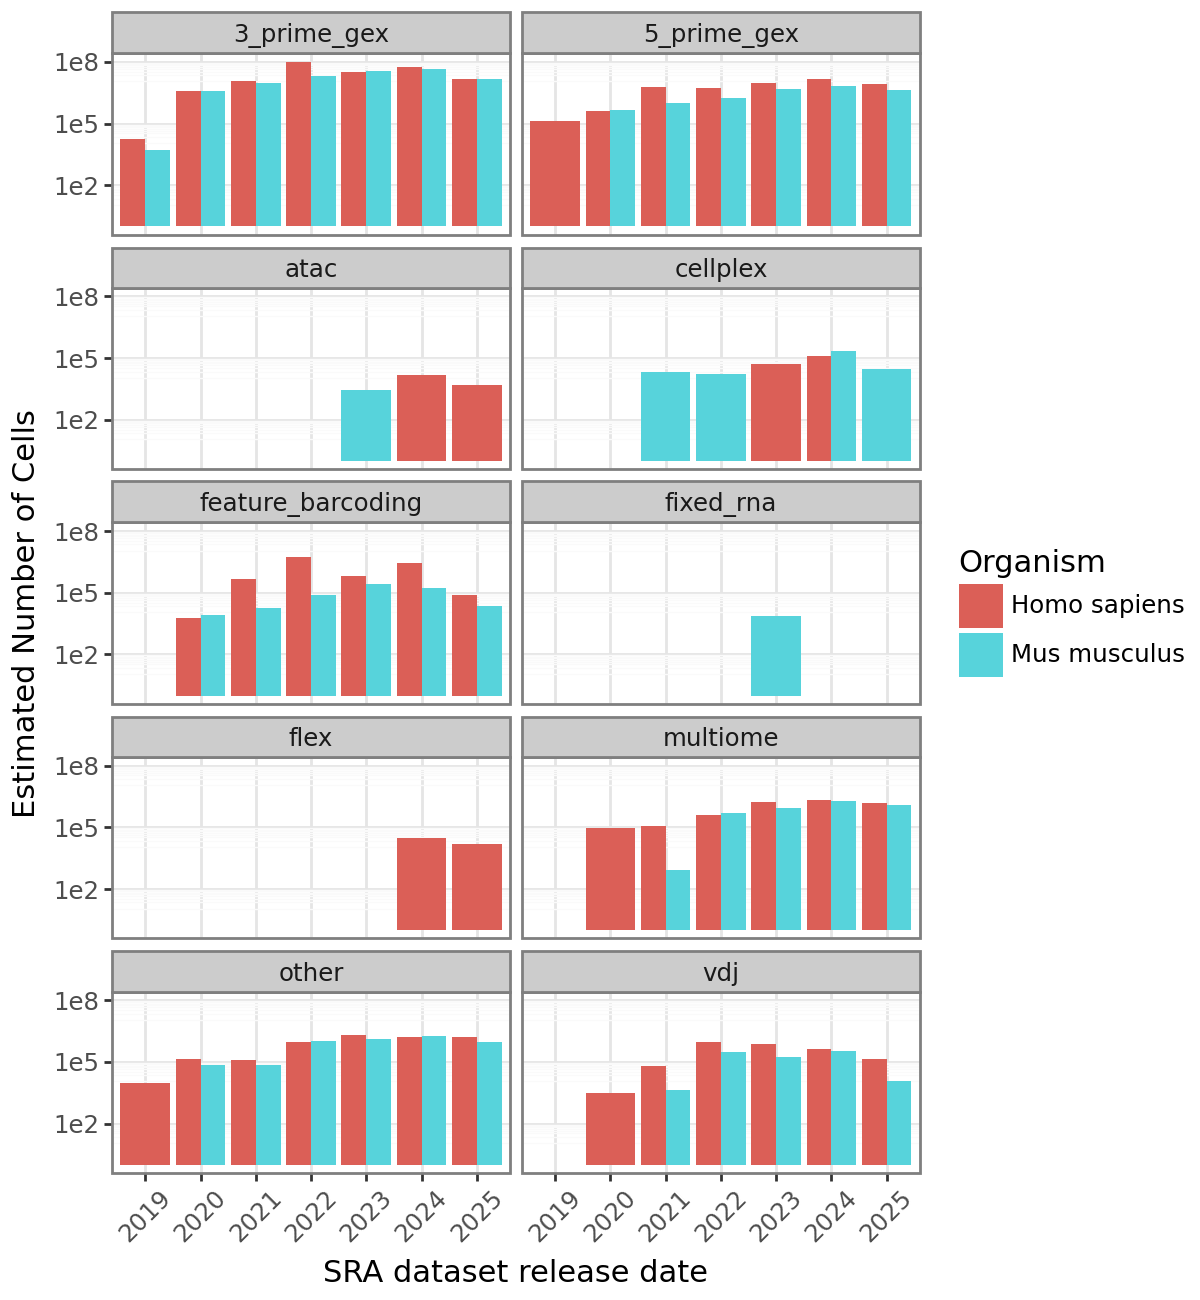

In [92]:
# plot the number of cells over time
p = (
    pn.ggplot(
        df_cells_sum, 
        pn.aes(x="release_date_year", y="estimated_number_of_cells", fill="organism")
    ) +
    pn.geom_col(position=pn.position_dodge(width=0.9)) +
    pn.scale_y_log10() +
    pn.facet_wrap("~tech_10x", ncol=2) +
    pn.labs(
        x = "SRA dataset release date",
        y = "Estimated Number of Cells",
        fill = "Organism",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(6, 6.5),
        axis_text_x=pn.element_text(angle=45, hjust=0.95),
    )
)
p

### Cells by month

In [86]:
# summarize cells by month and tech_10x
df_cells_sum = df_cells.groupby(["release_date_month", "tech_10x", "organism"]).agg({"estimated_number_of_cells": "sum"}).reset_index()
# filter
df_cells_sum = df_cells_sum[df_cells_sum["organism"].isin(["Homo sapiens", "Mus musculus"])]
# if tech_10x == "not_applicable", set to "other"
df_cells_sum["tech_10x"] = df_cells_sum["tech_10x"].apply(lambda x: "other" if x == "not_applicable" else x)
df_cells_sum

,release_date_month,tech_10x,organism,estimated_number_of_cells
0,2019-10,3_prime_gex,Mus musculus,4971
1,2019-11,3_prime_gex,Homo sapiens,16965
...,...,...,...,...
1112,2025-06,multiome,Mus musculus,115088
1115,2025-06,vdj,Homo sapiens,45181


/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/home/nickyoungblut/miniforge3/envs/SRAgent_nb/lib/p

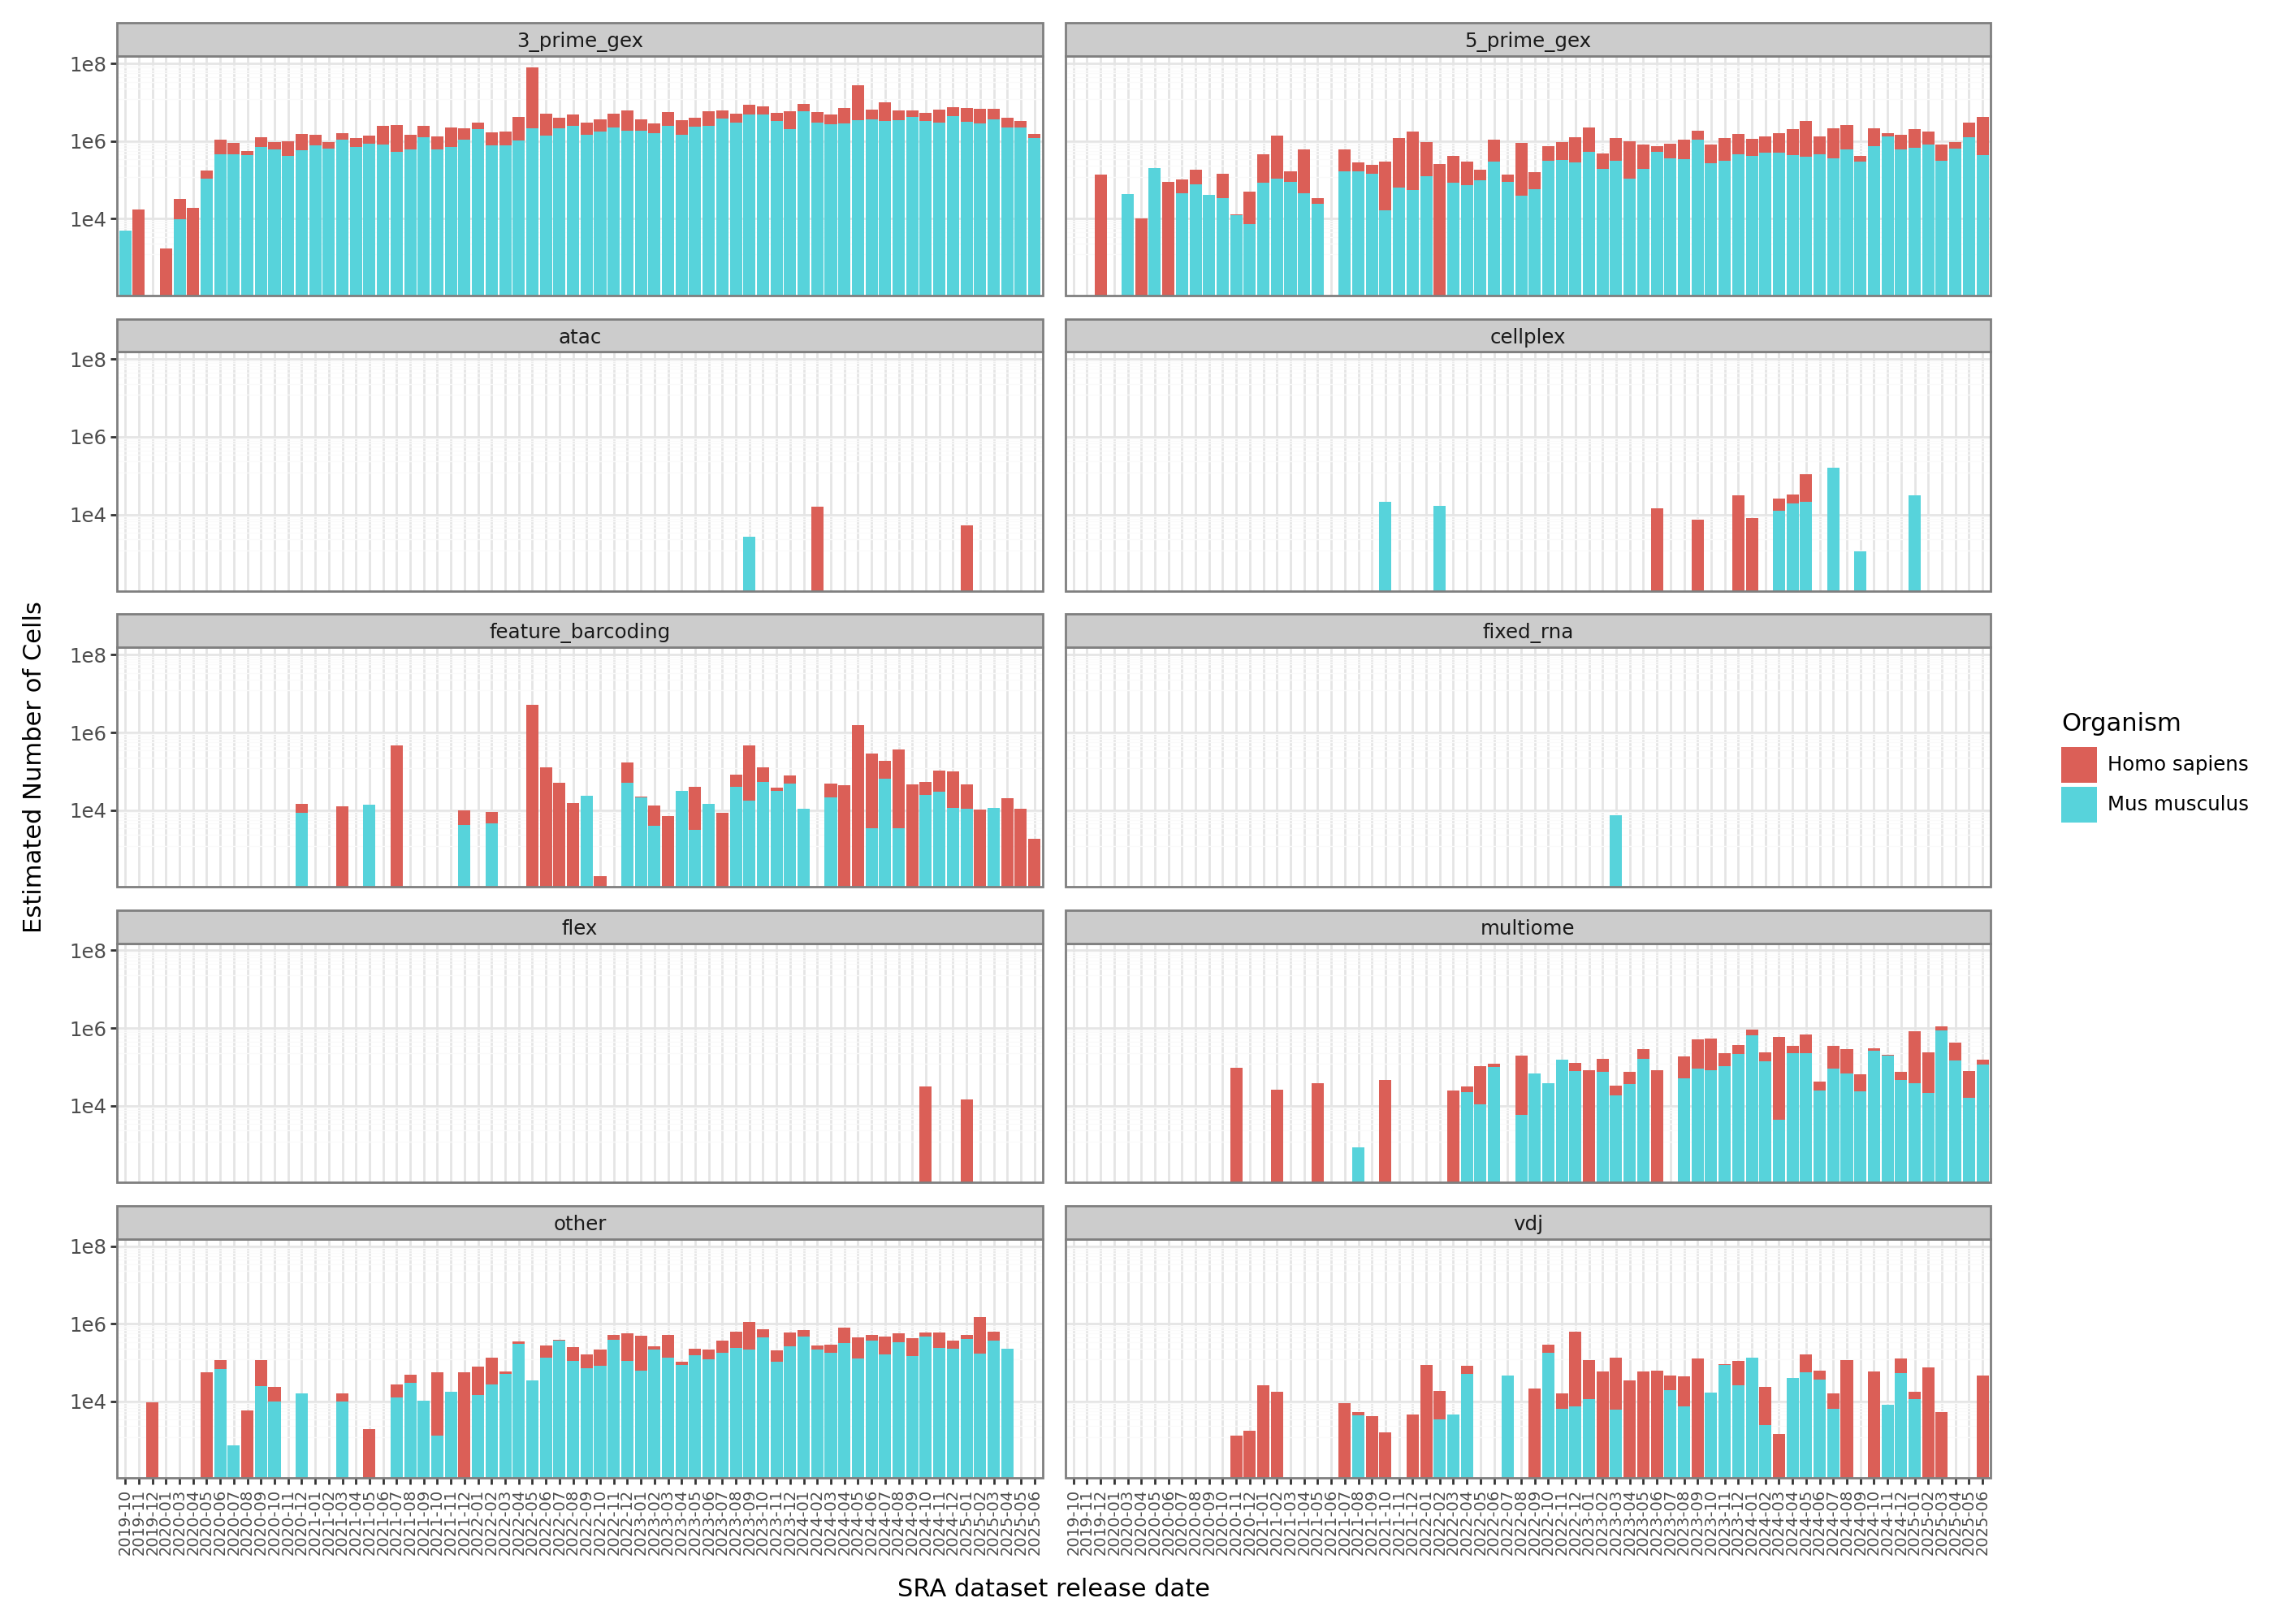

In [88]:
# plot the number of cells over time
p = (
    pn.ggplot(
        df_cells_sum, 
        pn.aes(x="release_date_month", y="estimated_number_of_cells", fill="organism")
    ) +
    pn.geom_col() +
    pn.scale_y_log10() +
    pn.facet_wrap("~tech_10x", ncol=2) +
    pn.labs(
        x = "SRA dataset release date",
        y = "Estimated Number of Cells",
        fill = "Organism",
    ) +
    pn.theme_bw() +
    pn.theme(
        figure_size=(14, 10),
        axis_text_x=pn.element_text(angle=90, hjust=0.9, size=7),
    )
)
p